In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from kepler_func import *
from IPython.core.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    overflow-x: auto !important;
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
'''))

%matplotlib inline


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/d2/967f_3k57458fwy_1s1dh8_w0000gn/T/ipykernel_47277/2998155965.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Get some data from NASA Horizons

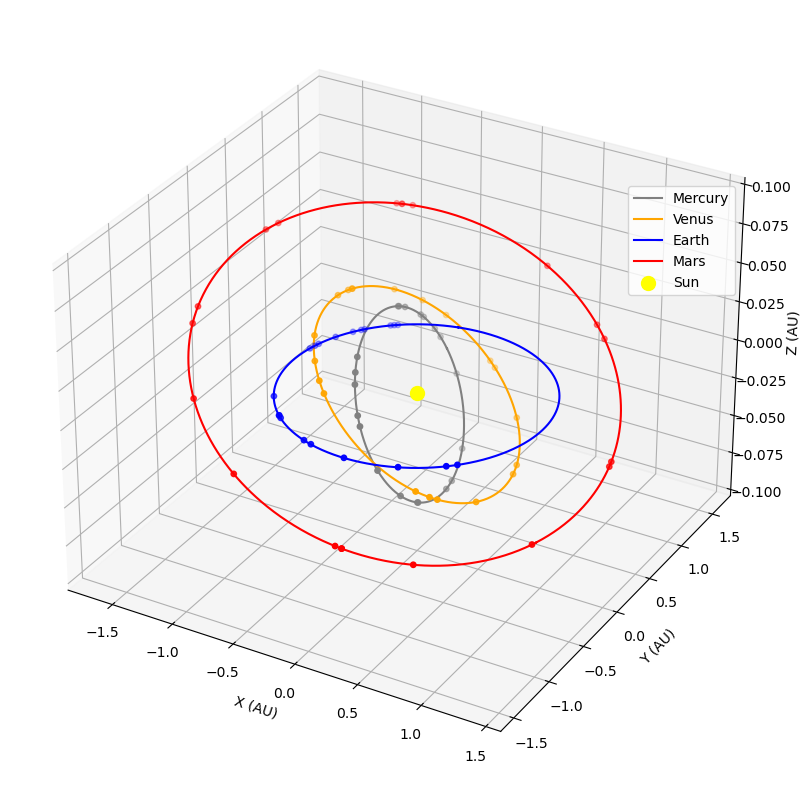

In [2]:
# Define planet IDs
planets = {
    'Mercury': 199,
    'Venus': 299,
    'Earth': 399,
    'Mars': 499
}

colors = {
        'Mercury': 'gray',
        'Venus': 'orange',
        'Earth': 'blue',
        'Mars': 'red'
    }

# Define epoch for orbital elements (Julian Date for 2021-Jan-01)
epoch = {'start': '2008-01-06', 'stop': '2009-01-06', 'step': '30d'}
# Define observation time range
obs_epochs = {'start': '1993-01-01', 'stop': '2023-01-01', 'step': '30d'}


orbitalObs_df, orbitalParams_df, true_anomaly_values_df = get_orbital_observations(planets, epoch, obs_epochs)

#print(true_anomaly_values_df.head())
#print(orbitalParams_df.head())
#print(orbitalObs_df.head())

In [3]:
# Initialize plot
#different_plots(planets, true_anomaly_values_df, orbitalObs_df)

In [4]:
# plot planets before and after transformation to Perifocal frame:
#perifocal_trans_plot(planets, orbitalObs_df, orbitalParams_df)

Run IRAS on Mercury coordinates:

In [5]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict = dict()
    IRAS_runOnCoordinatesResultsDict['Mercury'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df)
    
    
    with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
        pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


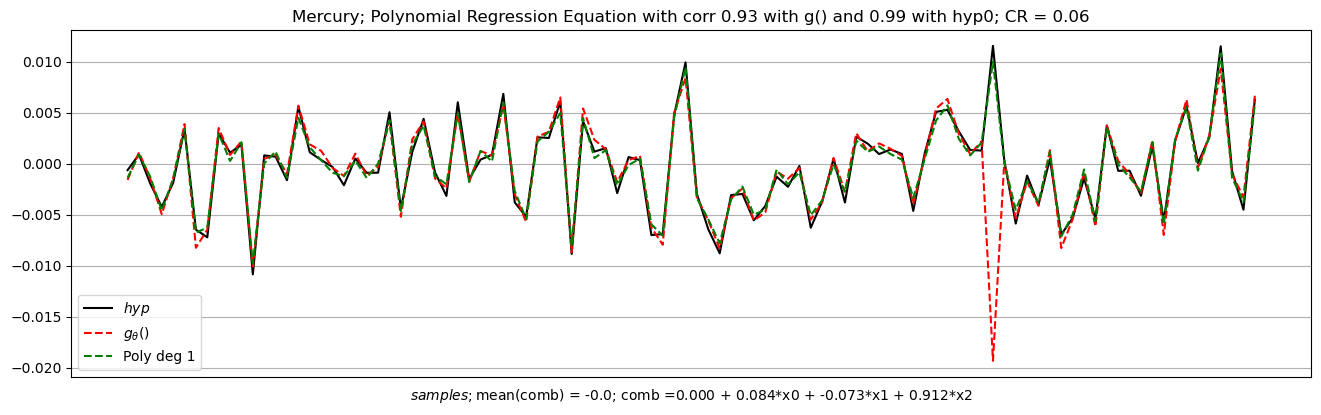

Mercury; GT plane eq: 0=0.000 + 0.091*x + -0.081*y + 0.993*z; IRAS-polyFit eq: 0=0.001 + 0.092*x + -0.079*y + 0.993*z; angle between normals is 0.1292 deg
sanity orbital plane eq: 0=[ 0.          0.09108063 -0.08108878  0.99253661]


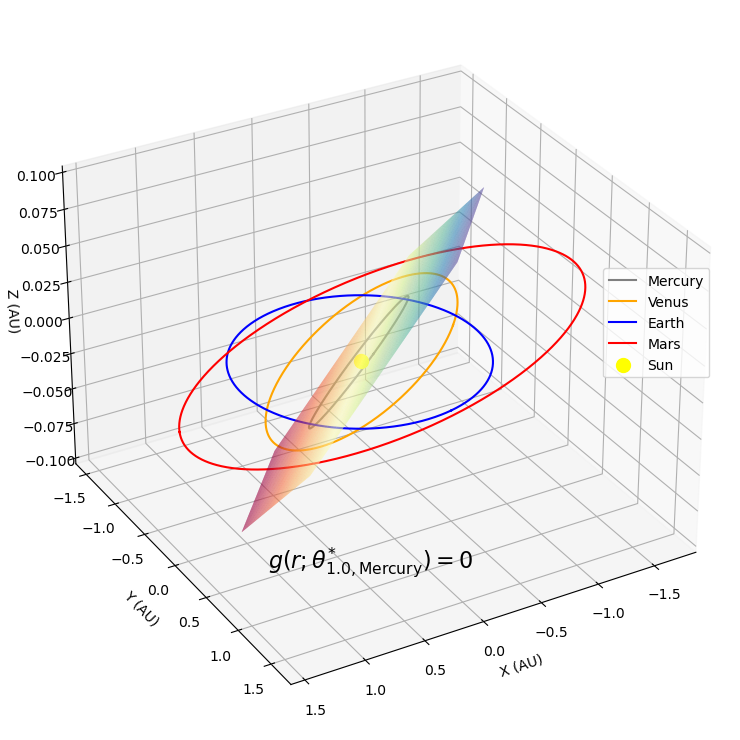

In [6]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))

highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury'])
print_IRAS_res(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp, true_anomaly_values_df, orbitalObs_df, orbitalParams_df, title3D=r'$g(r;\theta^{*}_{1.0,\mathrm{Mercury}})=0$')

In [7]:
alpha = 1e-2
orbitalParams_df['est_orbitalPlaneNormal'] = orbitalParams_df.apply(lambda row: add_est_orbitalPlaneNormal(row, 'Mercury', IRAS_runOnCoordinatesResultsDict['Mercury']['implicitPolyDictList'][0]['coefficients'][1:][:,None], 'est_orbitalPlaneNormal'), axis=1)
orbitalObs_df['r_proj2EstOrbitalPlane'] = orbitalObs_df.apply(lambda row: proj_r_2EstOrbitalPlane(row, orbitalParams_df), axis=1)
orbitalObs_df['r_2D_est'] = orbitalObs_df.apply(lambda row: transform_2_2D(row, orbitalParams_df, np.array([[1], [0], [0]]), est=True), axis=1)
orbitalObs_df['r_2D_est_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_est=True, est=True), axis=1)


orbitalObs_df['v_proj2EstOrbitalPlane'] = orbitalObs_df.apply(lambda row: proj_r_2EstOrbitalPlane(row, orbitalParams_df, to_v=True), axis=1)
orbitalObs_df['v_2D_est'] = orbitalObs_df.apply(lambda row: transform_2_2D(row, orbitalParams_df, np.array([[1], [0], [0]]), est=True, to_v=True), axis=1)
orbitalObs_df['v_2D_est_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_est=True, to_v=True, est=True), axis=1)
orbitalObs_df['L_2D_est'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True), axis=1)
orbitalObs_df['L_2D_est_noisy'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True, noisy=True), axis=1)

/Users/ron.teichner/Projects/IRAS/kepler_func.py:335: RuntimeWarning: invalid value encountered in divide
  return r - (n.T@r / np.power(np.linalg.norm(n), 2)) * n
/Users/ron.teichner/Projects/IRAS/kepler_func.py:267: RuntimeWarning: invalid value encountered in divide
  u = (np.cross(normal[:,0],a[:,0]) / np.linalg.norm(np.cross(normal[:,0],a[:,0])))[:,None]
/Users/ron.teichner/Projects/IRAS/kepler_func.py:335: RuntimeWarning: invalid value encountered in divide
  return r - (n.T@r / np.power(np.linalg.norm(n), 2)) * n
/Users/ron.teichner/Projects/IRAS/kepler_func.py:267: RuntimeWarning: invalid value encountered in divide
  u = (np.cross(normal[:,0],a[:,0]) / np.linalg.norm(np.cross(normal[:,0],a[:,0])))[:,None]


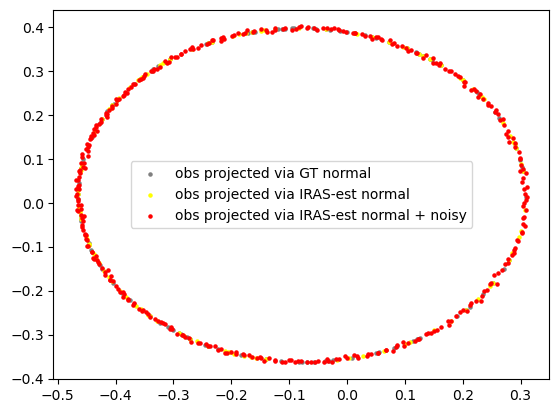

In [8]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

alpha = np.asarray([Obs['r_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta = np.asarray([Obs['r_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

alpha_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

alpha_hat_noisy = np.asarray([Obs['r_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat_noisy = np.asarray([Obs['r_2D_est_noisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

plt.figure()
indices = np.random.permutation(np.arange(len(alpha_hat)))[:int(0.3*len(alpha_hat))]
plt.scatter(x=alpha[indices], y=beta[indices], s=5, color=colors['Mercury'], label='obs projected via GT normal')
indices = np.random.permutation(np.arange(len(alpha_hat)))[:int(0.3*len(alpha_hat))]
plt.scatter(x=alpha_hat[indices], y=beta_hat[indices], s=5, color='yellow', label='obs projected via IRAS-est normal')
indices = np.random.permutation(np.arange(len(alpha_hat)))
plt.scatter(x=alpha_hat_noisy[indices], y=beta_hat_noisy[indices], s=5, color='red', label='obs projected via IRAS-est normal + noisy')
plt.legend()
plt.show()

In [9]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury2D'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runOn2D=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


In [10]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))
IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']
orbitalObs_df['r_2D_est_proj2estEllipse'] = orbitalObs_df.apply(lambda row: project_point_to_ellipse(row, IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params']), axis=1)


Pearson correlation between g() and estimated ellipse is 0.992


/Users/ron.teichner/Projects/IRAS/kepler_func.py:580: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[1], colors='blue', label='fitted ellipse for IRAS g()')


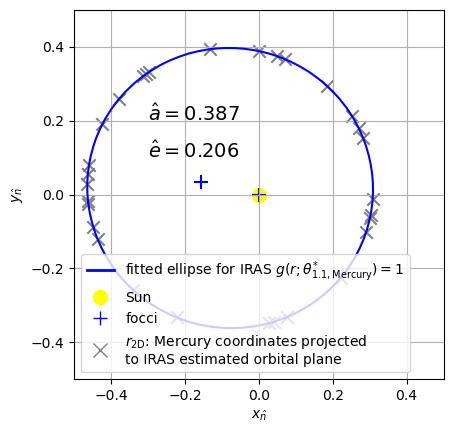

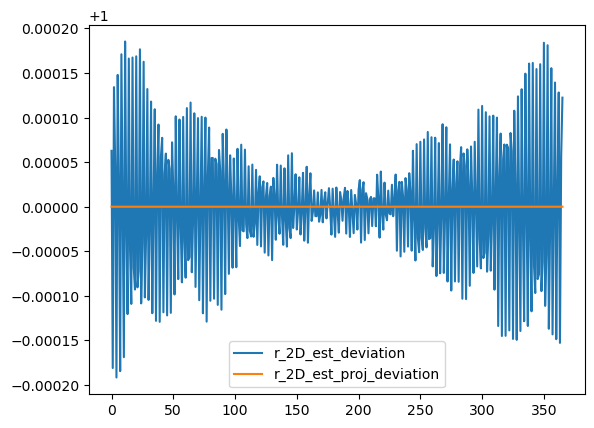

In [11]:
plot_est2D_ellipse(IRAS_runOnCoordinatesResultsDict, 'Mercury', orbitalParams_df, orbitalObs_df, title=r'$g(r; \theta^{*}_{1.1,\mathrm{Mercury}})=1$')

In [12]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury2D_v'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runOn2D_v=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)

In [13]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))
IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']
orbitalObs_df['v_2D_est_proj2estEllipse'] = orbitalObs_df.apply(lambda row: project_point_to_ellipse(row, IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], to_v=True), axis=1)



Pearson correlation between g() and estimated ellipse is 0.911


/Users/ron.teichner/Projects/IRAS/kepler_func.py:580: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[1], colors='blue', label='fitted ellipse for IRAS g()')


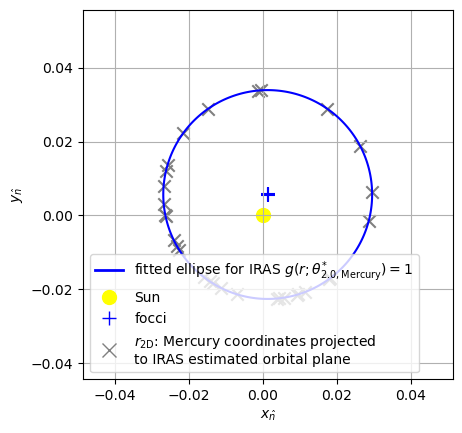

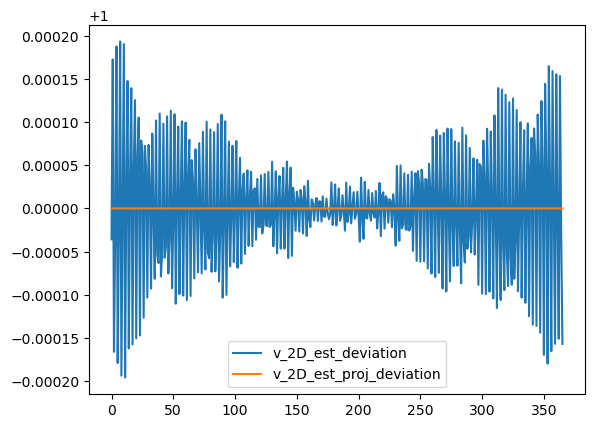

In [14]:
plot_est2D_ellipse(IRAS_runOnCoordinatesResultsDict, 'Mercury', orbitalParams_df, orbitalObs_df, to_v=True, title=r'$g(r; \theta^{*}_{2.0,\mathrm{Mercury}})=1$')

In [ ]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runCoordinates_n_Velocities=True, externalReport=True)
    #IRAS_runOnCoordinatesResultsDict['Planets_2DK2'] = runIRAS(list(planets.keys()), true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runCoordinates_n_Velocities=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


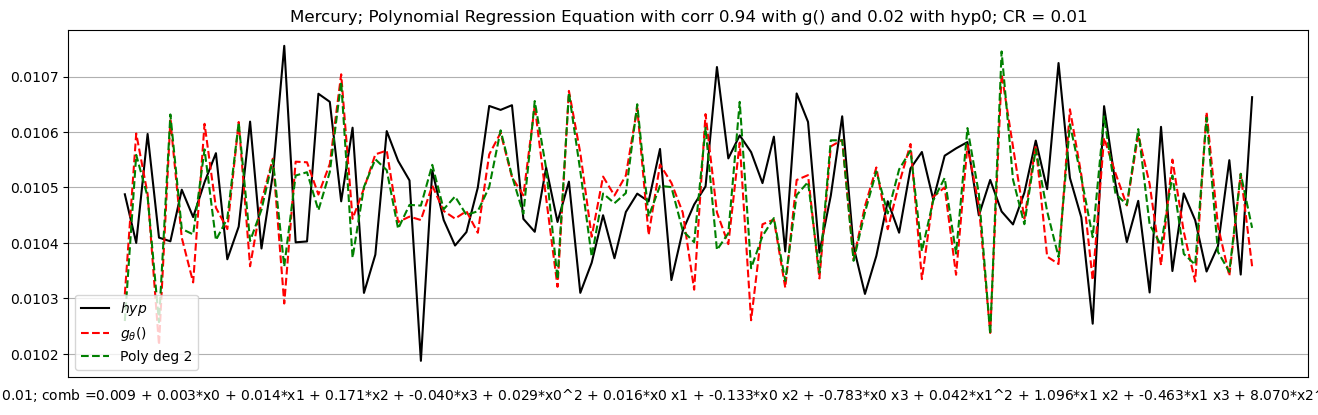

In [13]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))

highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'])
print_IRAS_res(IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'], highScoreHyp)

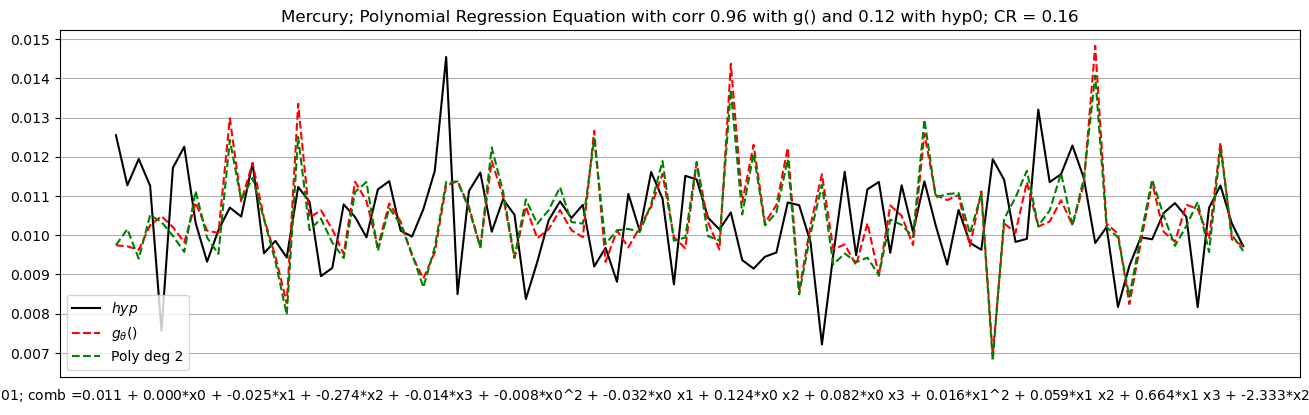

pCorrOfPolyFit hyp 2 comb = 0.1454480877239329


In [34]:
from sklearn.linear_model import LinearRegression
def print_IRAS_res1(IRAS_runOnCoordinatesResults, ih, L_2D_est_noisy):

    s=0
    fontize = 10
    
    implicitPolyDict = IRAS_runOnCoordinatesResults['implicitPolyDictList'][ih]
    CR_zeta1 = implicitPolyDict['CR_zeta1']

    planet = IRAS_runOnCoordinatesResults['planet']
    singleBatch = implicitPolyDict['singleBatch']
    
    combination = implicitPolyDict['combination']
    hypotheses_regulations = implicitPolyDict['hypotheses_regulations']
    degreeOfPolyFit = IRAS_runOnCoordinatesResults['degreeOfPolyFit'][ih]
    
    pearsonCorr = pd.Series(combination[s].detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[s,:,0].flatten()))
    #print(f'sanity1={pd.Series(L_2D_est_noisy).corr(pd.Series(hypotheses_regulations[s,:,0].flatten()))}')

    #print(f'L_2D_est_noisy.shape={L_2D_est_noisy.shape}')
    #print(f'hypotheses_regulations.shape={hypotheses_regulations.shape}')

    #plt.figure()
    #plt.plot(L_2D_est_noisy, label='L_2D_est_noisy')
    #plt.plot(hypotheses_regulations[s,:,0], label='hyp')
    #plt.legend()
    #plt.show()

    
    
    
    tVec = np.arange(singleBatch.shape[1])[:,None]
    comb = combination[s].detach().cpu().numpy().flatten()        
    hyp = hypotheses_regulations[s,:,0].flatten()
    #print(f'sanity2={pd.Series(L_2D_est_noisy).corr(pd.Series(hyp))}')
    #hyp = (hyp-hyp.mean())/hyp.std()
    comb = (comb-comb.mean())/comb.std()
    if pearsonCorr < 0:
        comb = -comb
    comb = comb*hyp.std() + hyp.mean()
    #print(f'hyp mean = {hyp.mean()}')
    #print(f'comb mean = {comb.mean()}')
    #print(f'degreeOfPolyFit={degreeOfPolyFit}')
    #print(f'singleBatch[s,:5]={singleBatch[s,:5]}')
    poly = PolynomialFeatures(degreeOfPolyFit)
    X_poly = poly.fit_transform(singleBatch[s])
    feature_names = poly.get_feature_names_out()
    #print(f'X_poly={X_poly}')    
            
    # Evaluate the polynomial function
    poly_comb = X_poly @ np.concatenate(([implicitPolyDict['intercept']], implicitPolyDict['coefficients'][1:]))
    pCorrOfPolyFit = np.abs(pd.Series(poly_comb).corr(pd.Series(comb)))
    pCorrOfPolyWithHyp = np.abs(pd.Series(poly_comb).corr(pd.Series(hyp)))
    titleStr = planet + f"; Polynomial Regression Equation with corr {str(round(pCorrOfPolyFit,2))} with g() and {str(round(pCorrOfPolyWithHyp,2))} with hyp{ih}; CR = {str(round(CR_zeta1.item(),2))}"

    polynomial_equation = poly_eq_str(implicitPolyDict['intercept'], implicitPolyDict['coefficients'], feature_names)
    
    nPoints2Plot = np.min([100, len(hyp)])
    
    plt.figure(figsize=(16,9/2))
    plt.title(titleStr)
    
    plt.plot(tVec[:nPoints2Plot], hyp[:nPoints2Plot], 'k', label=r'$hyp$')
    plt.plot(tVec[:nPoints2Plot], comb[:nPoints2Plot],'r--', label=r'$g_\theta()$')      
    
    plt.plot(tVec[:nPoints2Plot], poly_comb[:nPoints2Plot] ,'g--', label=f'Poly deg {degreeOfPolyFit}')      
    
    plt.xlabel(r'$samples; $' + f"mean(comb) = {str(round(poly_comb.mean(),2))}; comb =" + polynomial_equation, fontsize=fontize)
    #plt.ylabel('Protein level', fontsize=fontize)
    plt.legend(loc='lower left', fontsize=fontize)
    plt.xticks([])
    #plt.yticks([])
    plt.grid()
    
    plt.show()

    #hyp to comb fit:
    degreeOfPolyFit_hypComb = 100
    poly = PolynomialFeatures(degreeOfPolyFit_hypComb)
    X_poly = poly.fit_transform(hyp[:,None])
    feature_names_hyp = poly.get_feature_names_out()
    model = LinearRegression()
    model.fit(X_poly, comb)
    poly_comb = model.predict(X_poly)
            
    pCorrOfPolyFit = np.abs(pd.Series(poly_comb).corr(pd.Series(comb)))
    print(f'pCorrOfPolyFit hyp 2 comb = {pCorrOfPolyFit}')
    
    

Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']
L_2D_est_noisy = np.asarray([Obs['L_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])

#plt.figure()
#plt.plot(L_2D_est_noisy, label='L_2D_est_noisy')
#plt.legend()

#print(f'L_2D_est_noisy.shape={L_2D_est_noisy.shape}')
print_IRAS_res1(IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'], highScoreHyp, L_2D_est_noisy)

In [16]:
# IRAS_train_script(observations, observations_tVec, hypotheses_regulations, titleStr='', nativeIRAS=True)
# with observations having shape of (N x T x F) and observations_tVec (N x T x 1). 
# Here N is the number of observed timeseries, T is the number of samples in each timeseries and F the number of observables. 
# The observations are in the variable observations and their corresponding times in observations_tVec. 
# In the input V the user can place an hypothesis. 
# The Pearson correlation between the hypothesis and the output of the algorithm is printed and their figure is plotted.
#   playerPerPatient = False

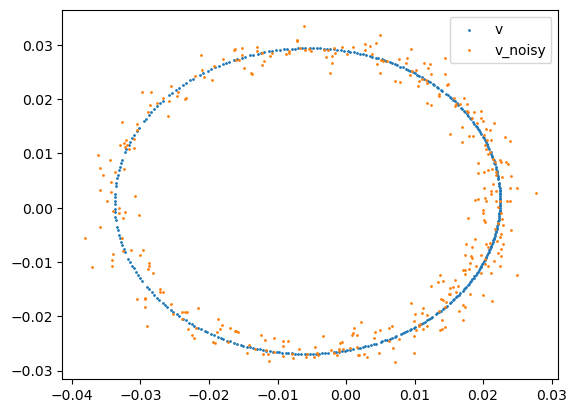

In [17]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

vx = np.asarray([Obs['v'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
vy = np.asarray([Obs['v'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

vx_n = np.asarray([Obs['vNoisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
vy_n = np.asarray([Obs['vNoisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

plt.figure()
plt.scatter(x=vx, y=vy, s=1, label='v')
plt.scatter(x=vx_n, y=vy_n, s=1, label='v_noisy')
plt.legend()
plt.show()


In [18]:
Obs.columns

Index(['target', 'datetime_jd', 'datetime_str', 'x', 'y', 'z', 'vx', 'vy',
       'vz', 'lighttime', 'range', 'range_rate', 'r', 'r_proj2OrbitalPlane',
       'r_2D', 'v', 'v_proj2OrbitalPlane', 'v_2D', 'L', 'L_2D', 'rNoisy',
       'vNoisy', 'L_Noisy', 'r_tag', 'r_tagNoisy', 'r_proj2EstOrbitalPlane',
       'r_2D_est', 'r_2D_est_noisy', 'v_proj2EstOrbitalPlane', 'v_2D_est',
       'v_2D_est_noisy', 'L_2D_est', 'L_2D_est_noisy'],
      dtype='object')

In [19]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

In [20]:
Obs.columns

Index(['target', 'datetime_jd', 'datetime_str', 'x', 'y', 'z', 'vx', 'vy',
       'vz', 'lighttime', 'range', 'range_rate', 'r', 'r_proj2OrbitalPlane',
       'r_2D', 'v', 'v_proj2OrbitalPlane', 'v_2D', 'L', 'L_2D', 'rNoisy',
       'vNoisy', 'L_Noisy', 'r_tag', 'r_tagNoisy', 'r_proj2EstOrbitalPlane',
       'r_2D_est', 'r_2D_est_noisy', 'v_proj2EstOrbitalPlane', 'v_2D_est',
       'v_2D_est_noisy', 'L_2D_est', 'L_2D_est_noisy'],
      dtype='object')

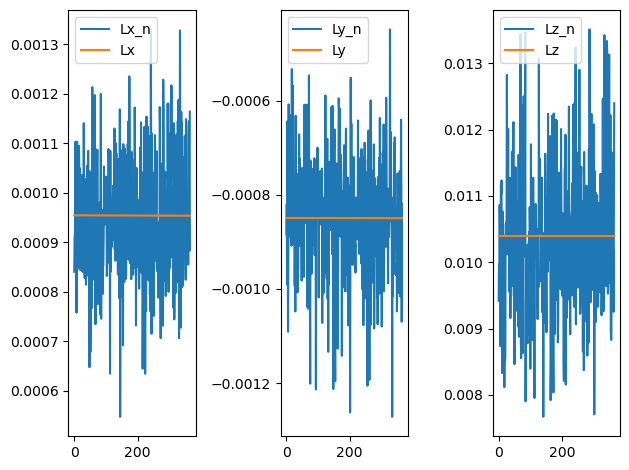

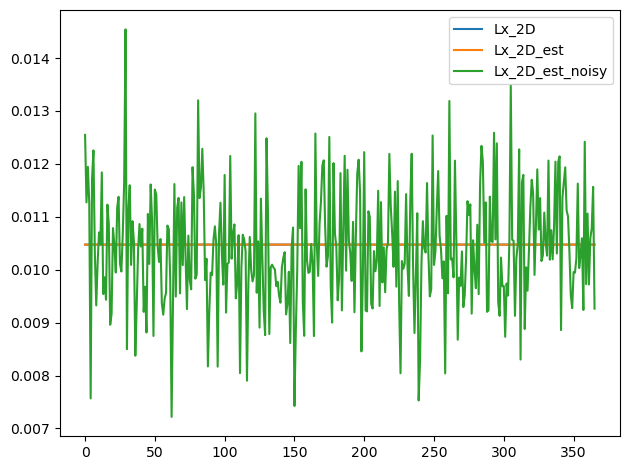

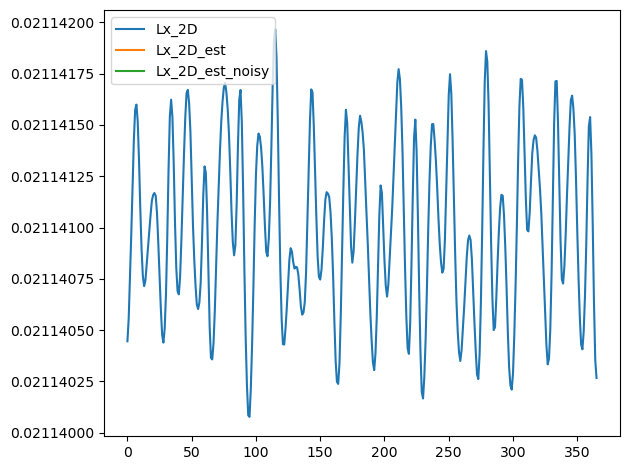

In [21]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']
Lx = np.asarray([Obs['L'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Ly = np.asarray([Obs['L'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
Lz = np.asarray([Obs['L'].to_numpy()[i][2,0] for i in range(Obs.shape[0])])

Lx_n = np.asarray([Obs['L_Noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Ly_n = np.asarray([Obs['L_Noisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
Lz_n = np.asarray([Obs['L_Noisy'].to_numpy()[i][2,0] for i in range(Obs.shape[0])])


plt.figure()
plt.subplot(1,3,1)
plt.plot(Lx_n, label='Lx_n')
plt.plot(Lx, label='Lx')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Ly_n, label='Ly_n')
plt.plot(Ly, label='Ly')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Lz_n, label='Lz_n')
plt.plot(Lz, label='Lz')
plt.legend()

plt.tight_layout()
plt.show()
############
Lx_2D = np.asarray([Obs['L_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est = np.asarray([Obs['L_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est_noisy = np.asarray([Obs['L_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])


plt.figure()
#plt.plot(Lx_n, label='Lx_n')
plt.plot(Lx_2D, label='Lx_2D')
plt.plot(Lx_2D_est, label='Lx_2D_est')
plt.plot(Lx_2D_est_noisy, label='Lx_2D_est_noisy')
plt.legend()

plt.tight_layout()
plt.show()

Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mars']
Lx_2D = np.asarray([Obs['L_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est = np.asarray([Obs['L_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est_noisy = np.asarray([Obs['L_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])

plt.figure()
#plt.plot(Lx_n, label='Lx_n')
plt.plot(Lx_2D, label='Lx_2D')
plt.plot(Lx_2D_est, label='Lx_2D_est')
plt.plot(Lx_2D_est_noisy, label='Lx_2D_est_noisy')
plt.legend()

plt.tight_layout()
plt.show()